## currect structure

## pre process

In [6]:
import yaml
import sys
sys.path.append('..')
from src.tools.db_manager import DBManager
with open('../config.yaml', 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

In [7]:
config['chromadb']['persist_directory'] = '../data/chroma'

In [8]:
db_manager = DBManager(**config['neo4jdb'], **config['chromadb'])

In [11]:
db_manager.vector_db.collection.query(
    query_texts=['network'],
    n_results=1
)

{'ids': [['c-bf7a8403-5811-4324-a7e7-f82c13cb8d78']],
 'embeddings': None,
 'documents': [['A network is a collection of interconnected elements']],
 'metadatas': [[{'name': 'network',
    'general': True,
    'type': 'Concept',
    'embedding_source': 'description'}]],
 'distances': [[0.6379055380821228]]}

In [12]:
generations = db_manager.vector_db.get_from_specific_source('generated')['metadatas']
generations_docs = db_manager.vector_db.get_from_specific_source('generated')['documents']
for i in range(len(generations)):
    generations[i]['documents']=generations_docs[i]

## test the correctness of general tagging

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [14]:
distance_of_general_generation = []
distance_of_specific_generation = []
for generation in tqdm(generations):
    is_general = generation['general']
    distance = db_manager.vector_db.query_from_specific_source(source='provided',
                                                       query_texts=[generation['documents']],
                                                       n_results=50)['distances']
    distance_np = np.array(distance[0])
    if is_general:
        distance_of_general_generation.append(distance_np)
    else:
        distance_of_specific_generation.append(distance_np)
average_distance_of_general_generation = np.average(np.array(distance_of_general_generation), axis=0)
average_distance_of_specific_generation = np.average(np.array(distance_of_specific_generation), axis=0)

  0%|          | 1/365 [00:00<01:04,  5.61it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 365/365 [00:45<00:00,  8.08it/s]


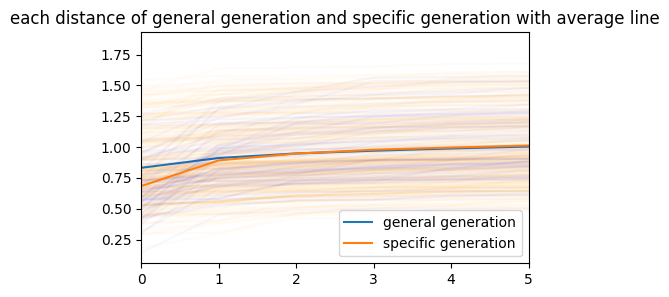

In [15]:
plt.figure(figsize=(5, 3))
plt.title('each distance of general generation and specific generation with average line')
for i in range(len(distance_of_general_generation)):
    plt.plot(distance_of_general_generation[i], alpha=0.03, color='orange')
plt.plot(average_distance_of_general_generation, label='general generation')
for i in range(len(distance_of_specific_generation)):
    plt.plot(distance_of_specific_generation[i], alpha=0.03, color='blue')
plt.plot(average_distance_of_specific_generation, label='specific generation')
plt.xlim(0,5)
plt.legend()
plt.show()

## find similar concepts for entity alignment

In [102]:
for generation in generations[10:15]:
    print("="*20)
    is_general = generation['general']
    name = generation['name']
    description = generation['documents']
    similar_generations = db_manager.vector_db.query_from_specific_source(source='generated',
                                                    query_texts=description,
                                                    n_results=11)
    print(f"{generation['name']}: {generation['documents']}")
    print(f"general: {is_general}")
    print("-"*10)
    for i in range(1, len(similar_generations['documents'][0])):
        print(similar_generations['metadatas'][0][i]['name'], end=': ')
        print(similar_generations['documents'][0][i])
    print()

discrete space-time: A discrete space-time is a space-time with one temporal dimension and multiple spatial dimensions
general: True
----------
multi-dimensional space: A multi-dimensional space is a space with more than three dimensions
spatial network: A spatial network is a network defined in physical space
temporal cores: Temporal cores are dense structures in temporal networks that cannot be expanded further
information dimension: Information dimension is a measure of the amount of information needed to describe the structure of a fractal or complex network
dynamical systems: Dynamical systems are systems that change over time
locality: The topological wave function satisfies a relaxed condition of locality as it acquires the same value along simplices of dimension larger than zero
temporal networks: Temporal networks capture the dynamics of interactions over time
finite parametric model: A finite parametric model is a probabilistic model with a fixed number of components
evolutio

## tackle paper with same name

results shows that generations with same name have similar description.

In [5]:
# improt the lib so that i can create dictory with default value
from collections import defaultdict
name_description_map = defaultdict(list)
for generation in generations:
    is_general = generation['general']
    name = generation['name']
    description = generation['documents']
    name_description_map[name].append(description)

In [7]:
# for name in set(name_description_map.keys()):
#     print(name, len(name_description_map[name]))
# sort by frequency
sorted_name_description_map = sorted(name_description_map.items(), key=lambda x: len(x[1]), reverse=True)

In [10]:
sorted_name_description_map[:25]

[('complex networks',
  ['Complex networks are networks with non-trivial topological features',
   'Complex networks are networks with non-trivial topological features',
   'Complex networks structures have been extensively used for describing complex natural and technological systems',
   'Complex networks are networks with non-trivial topological features, such as small-worldness and scale-free degree distribution',
   'Complex networks are a powerful paradigm to model complex systems',
   'Complex networks are networks with non-trivial topological features',
   'The structure of complex networks has been of interest in many scientific and engineering disciplines over the decades',
   'Complex networks have attracted increasing interest from various fields of science',
   'Complex networks are networks with non-trivial topological features',
   'Complex networks are networks with non-trivial topological features',
   'Complex networks are networks with non-trivial topological feature